In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import re
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from keras.layers import (Activation, AveragePooling2D, BatchNormalization,
                          Conv2D, Dense, Dropout, Embedding, Flatten, Input,
                          MaxPooling2D)
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.optimizers import Adam, SGD

import warnings
warnings.filterwarnings('ignore')

In [3]:
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [4]:
pyhsical_devices = tf.config.list_physical_devices('GPU')
print('Num GPUs: ', len(pyhsical_devices))

Num GPUs:  1


In [5]:
emotion_label = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

In [6]:
loc = '/content/drive/MyDrive/Study/DS/Computer Vision/Face Emotion Detection/'
df = pd.read_csv(f'{loc}/data/train.csv')
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [7]:
df = df.sample(frac = 1, random_state = 0)

Sample Image

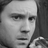

In [8]:
array = np.array(str(df.loc[0, 'pixels']).split(' '), dtype=np.uint8)
array = np.reshape(array, (48, 48))

new_image = Image.fromarray(array)
new_image

### Data Preprocessing

In [9]:
df.isnull().sum()[df.isnull().sum()>0]
# No null values.

Series([], dtype: int64)

In [10]:
df['emotion'] = df['emotion'].astype('category')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28709 entries, 18082 to 2732
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   emotion  28709 non-null  category
 1   pixels   28709 non-null  object  
dtypes: category(1), object(1)
memory usage: 1.5+ MB


### Univariate Analysis

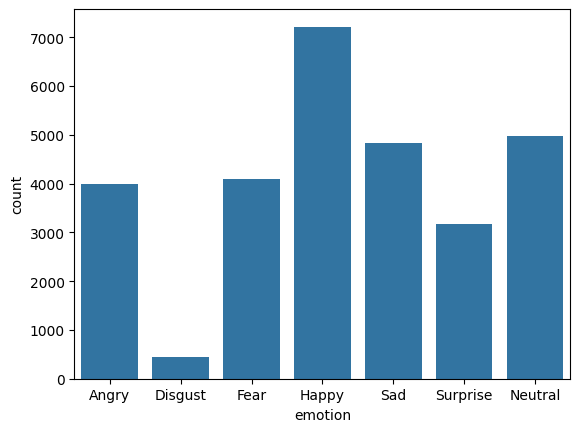

In [12]:
sns.countplot(x = 'emotion', data = df, order = list(emotion_label.keys()))
plt.xticks(ticks = list(emotion_label.keys()), labels = list(emotion_label.values()))
plt.show()

Inference:

1. Disgust values are very less. We could try turning Images at  certain angle to create more data.
2.

### Feature Engineering

#### Splitting the data in Train and Validation

In [13]:
data = df['pixels'].to_list()
x = []

for j in data:
  xx = [int(i) for i in str(j).split(' ')]
  xx = np.asarray(xx)
  xx = xx / 255
  xx = xx.reshape(48, 48)
  x.append(xx.astype('float32'))

x = np.asarray(x)
x = np.expand_dims(x, -1)

y = df['emotion']

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.35, random_state=123)
x_train.shape

(18660, 48, 48, 1)

In [15]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([3995,  436, 4097, 7215, 4830, 3171, 4965]))

In [16]:
class_weights = class_weight.compute_class_weight(
        class_weight = 'balanced',
        classes = np.unique(y),
        y = y)

In [17]:
class_weights = dict(zip(np.unique(y), class_weights))
class_weights

{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8491274770777877,
 5: 1.293372978330405,
 6: 0.8260394187886635}

### Creating a simple CNN for now.

In [18]:
def cnn_model(input_shape=(48,48,1)):
    num_classes = 7

    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'i', input_shape = input_shape))
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'c1_1'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'c1_2'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), name = 'p1_1'))

    model.add(Dropout(0.3, name = 'd1_1')) #the 2-nd block

    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'c2_1'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'c2_2'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'c2_3'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), name = 'p2_1'))

    model.add(Dropout(0.3, name = 'd2_1')) #the 3-rd block

    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c3_1'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c3_2'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c3_3'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c3_4'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), name = 'p3_1'))

    model.add(Dropout(0.3, name = 'd3_1'))#the 4-th block

    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c4_1'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c4_2'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c4_3'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'c4_4'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), name = 'p4_1'))

    model.add(Dropout(0.3, name = 'd4_1'))   #the 5-th block

    model.add(Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'c5_1'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'c5_2'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'c5_3'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'c5_4'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), name = 'p5_1'))

    model.add(Dropout(0.3, name = 'd5_1'))  #the 6-th block

    model.add(Flatten(name = 'f')) #Flatten and output

    model.add(Dense(500, activation='relu', name = 'h'))
    model.add(Dense(num_classes, activation='softmax', name = 'o'))

    return model

In [19]:
model = cnn_model()
opt = Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 i (Conv2D)                  (None, 48, 48, 64)        640       
                                                                 
 c1_1 (Conv2D)               (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 c1_2 (Conv2D)               (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 p1_1 (MaxPooling2D)         (None, 24, 24, 64)        0

#### Implementing Data Augmentation

In [28]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
    )

model.fit(
    datagen.flow(x, y, batch_size=64, subset='training'),
    validation_data = datagen.flow(x, y, batch_size=64, subset='validation'),
    epochs = 100,
    class_weight = class_weights,
    use_multiprocessing = True
    )

Epoch 1/100
359/359 [==============================] - 47s 129ms/step - loss: 1.8915 - accuracy: 0.1997 - val_loss: 2.0282 - val_accuracy: 0.1437
Epoch 2/100
359/359 [==============================] - 46s 127ms/step - loss: 1.8809 - accuracy: 0.1886 - val_loss: 1.9289 - val_accuracy: 0.1853
Epoch 3/100
359/359 [==============================] - 45s 124ms/step - loss: 1.8682 - accuracy: 0.2067 - val_loss: 1.9712 - val_accuracy: 0.1235
Epoch 4/100
359/359 [==============================] - 45s 126ms/step - loss: 1.8517 - accuracy: 0.2101 - val_loss: 1.8277 - val_accuracy: 0.2724
Epoch 5/100
359/359 [==============================] - 45s 126ms/step - loss: 1.8342 - accuracy: 0.2295 - val_loss: 1.8922 - val_accuracy: 0.2604
Epoch 6/100
359/359 [==============================] - 45s 125ms/step - loss: 1.8266 - accuracy: 0.2339 - val_loss: 1.8841 - val_accuracy: 0.2515
Epoch 7/100
359/359 [==============================] - 45s 126ms/step - loss: 1.8048 - accuracy: 0.2454 - val_loss: 1.8122 -

In [29]:
y_pred = []
y_pred_score = model.predict(x_val)
for i in y_pred_score:
  y_pred.append(i.argmax())

315/315 [==============================] - 4s 14ms/step


In [30]:
print(classification_report(y_val, y_pred, labels = list(set(y_pred))))

              precision    recall  f1-score   support

           0       0.60      0.64      0.62      1377
           1       0.57      0.94      0.71       163
           2       0.72      0.38      0.49      1482
           3       0.93      0.84      0.88      2537
           4       0.55      0.66      0.60      1734
           5       0.79      0.81      0.80      1041
           6       0.61      0.74      0.67      1715

    accuracy                           0.70     10049
   macro avg       0.68      0.72      0.68     10049
weighted avg       0.71      0.70      0.69     10049



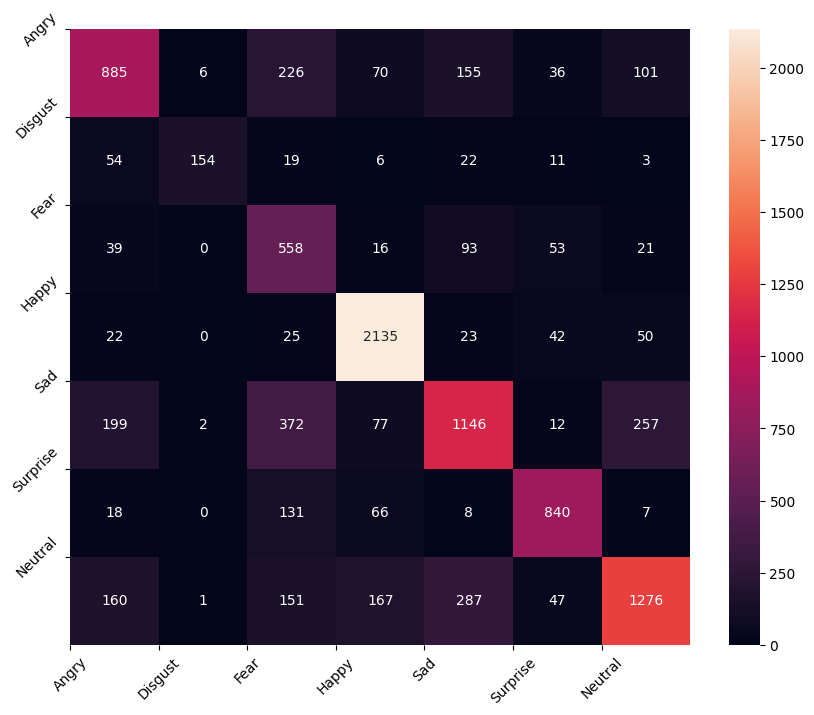

In [31]:
cm = pd.DataFrame(confusion_matrix(y_pred, y_val))
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks(ticks = list(emotion_label.keys()), labels = list(emotion_label.values()), rotation = 45)
plt.yticks(ticks = list(emotion_label.keys()), labels = list(emotion_label.values()), rotation = 45)
plt.show()

### Saving Model

In [32]:
default = 'model_'
accuracy = accuracy_score(y_pred, y_val)
# precision = precision_score(y_pred, y_val, average = 'weighted')

In [33]:
# name = f'{default}{int(ret_latest_file(default)) + 1}'
name = f'{default}_{accuracy}'

model_json = model.to_json()
try:
  os.mkdir(f'{loc}Models/{name}')
except:
  pass

with open(f'{loc}Models/{name}/{name}.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(f'{loc}Models/{name}/{name}.h5')
print("Saved model to disk")

Saved model to disk
